In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Assignment 4: Transfer Learning

#### Student Name: Francis Kurian

In this assignment,  you will use a pretrained model such as VGG16 to perform a new classification task. We will use The dataset (https://www.kaggle.com/c/aptos2019-blindness-detection) consisted of 3,662 labeled, high resolution color images for the training set, and 1,928 unlabeled for the test set. 
Images are classified into 5 groups according to the severity of DR present. Label 0 represents the control group. Labels 1–4 represent mild, moderate, severe, and proliferative DR, respectively.


In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GaussianNoise, GaussianDropout
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import vgg16
from keras.models import Model

## Load the data

In [15]:
data_path="/content/drive/MyDrive/atops-sample"
df = pd.read_csv(data_path+"/train.csv")
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

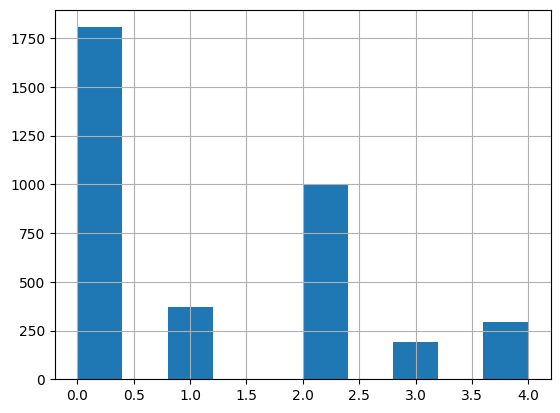

In [16]:
df['diagnosis'].hist()
df['diagnosis'].value_counts()

In [17]:
df['id_code'] = df['id_code'].astype(str)+'.png'
df['diagnosis'] = df['diagnosis'].astype('str')

#### Create a data generator

In [18]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 16
IMAGE_SIZE = (224,224)

datagen=ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_gen=datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_path+"/train_images_sample",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    subset='training')

test_gen=datagen.flow_from_dataframe(
    dataframe=df,
    directory=data_path+"/train_images_sample",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical", 
    target_size=IMAGE_SIZE,
    subset='validation')

Found 240 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 3362 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


Found 60 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 3362 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


## Define the Model

#### Load the VGG16 Model 

In [34]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [28]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Freeze the vgg16 layers

In [35]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

#### Add your own Layers

Use up to the the block4_pool layer of the vgg16 model and add 2 Fully Connected layers of your own at the end:

In [53]:
# Use up to the the block4_pool layer of the vgg16 model and add 2 Fully Connected layers of your own at the end:
# Get the output of the block4_pool layer
block4_pool_output = base_model.get_layer('block4_pool').output

# Add your own fully connected layers
x = Dense(512, activation='relu')(block4_pool_output)
x = Flatten()(x)
# x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

## Train the  Model


In [54]:
callback = []
callback += [ModelCheckpoint('atops.h5',save_best_only=True,mode='min')]
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [55]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

In [56]:
model.fit_generator(generator=train_gen,              
                                    steps_per_epoch=len(train_gen),
                                    validation_data=test_gen,                    
                                    validation_steps=len(test_gen),
                                    epochs=10,
                                    callbacks = [early_stop, model_checkpoint], 
                                    use_multiprocessing = False,
                                    verbose=1)

<ipython-input-56-efc37055608b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_gen,


Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 17.4626 - accuracy: 0.4500 
Epoch 1: val_loss improved from inf to 1.02356, saving model to best_weights.h5
15/15 [==============================] - 203s 13s/step - loss: 17.4626 - accuracy: 0.4500 - val_loss: 1.0236 - val_accuracy: 0.6167
Epoch 2/10
15/15 [==============================] - ETA: 0s - loss: 1.6685 - accuracy: 0.4875 
Epoch 2: val_loss did not improve from 1.02356
15/15 [==============================] - 192s 13s/step - loss: 1.6685 - accuracy: 0.4875 - val_loss: 1.0958 - val_accuracy: 0.6667
Epoch 3/10
15/15 [==============================] - ETA: 0s - loss: 1.0420 - accuracy: 0.6583 
Epoch 3: val_loss improved from 1.02356 to 0.87114, saving model to best_weights.h5
15/15 [==============================] - 201s 14s/step - loss: 1.0420 - accuracy: 0.6583 - val_loss: 0.8711 - val_accuracy: 0.6833
Epoch 4/10
15/15 [==============================] - ETA: 0s - loss: 0.9864 - accuracy: 0.6625 
Epoch 4: val_l